In [85]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
from WindPy import w
from sklearn import tree, linear_model
%matplotlib inline

In [2]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [3]:
ldf = pd.read_excel('D:/workspace/crusader/data/list.xlsx')
ldf = ldf.dropna().set_index(u'代码')

In [5]:
DATA_DIR = 'D:/Data/industry/'
industry = [x for x in os.listdir(DATA_DIR)]

In [6]:
df = ''
for ind in industry:
    files = [f for f in os.listdir('%s/%s'%(DATA_DIR, ind))]
    for f in files:
        fname = '%s/%s/%s'%(DATA_DIR, ind, f)
        if not isinstance(df, pd.DataFrame):
            df = pd.read_excel(fname)
        else:
            tdf = pd.read_excel(fname)
            cols = tdf.columns.difference(df.columns)
            df = df.merge(tdf[cols], how='outer', left_index=True, right_index=True)

In [7]:
df = df.fillna(method='ffill').resample('BM').last()

In [8]:
df = df[(df.index >= '2004-01-01') & (df.index <= '2018-02-28')]

In [9]:
df = df.dropna(axis=1)

In [10]:
df.shape

(170, 114)

In [11]:
INDEX_DIR = 'D:/Data/index'

In [12]:
dic = {}
for f in os.listdir(INDEX_DIR):
    if f.startswith('881') or f.startswith('886'):
        fname = '%s/%s'%(INDEX_DIR, f)
        temp = pd.read_excel(fname)
        dic[f.rstrip('.xlsx')] = temp['close']
sdf = pd.DataFrame(dic)

In [13]:
rdf = sdf.resample('BM').last().pct_change()

In [14]:
rdf = rdf[(rdf.index >= '2004-01-01') & (rdf.index <= '2018-02-28')]

In [15]:
rdf.shape

(170, 68)

In [16]:
fea = pd.DataFrame(index=df.index, columns=df.columns)
for date in df.index:
    past = df[df.index <= date][-60:] # 过去5年
    fea.loc[date] = (df.loc[date] - past.mean()) / past.std()

In [17]:
fea = fea[fea.index >= '2006-01-01']
rdf = rdf[rdf.index >= '2006-01-01']

In [78]:
fea.shape, rdf.shape

((146, 114), (146, 68))

# 行业市场特征

In [134]:
code = '886001.WI'
acc_ret = rdf[code] - rdf['881001.WI']

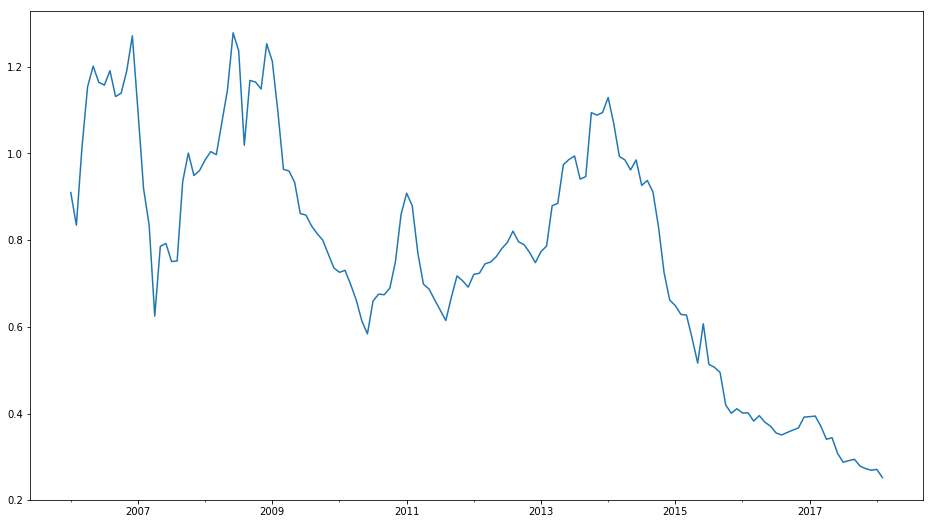

In [135]:
nav = (1+acc_ret).cumprod()
nav.plot(figsize=(16, 9))

In [136]:
ret12m = nav.pct_change(12)

In [138]:
ret12m[ret12m > 0.5]

2008-04-30    0.716144
2008-06-30    0.613275
2008-07-31    0.647184
dtype: float64

In [139]:
key = 0
pred = {}
for date in ret12m[ret12m > 0.5].index:
    start_date = date - datetime.timedelta(365)
    scenario = fea[(fea.index >= start_date) & (fea.index <= date)]
    sc_nav = nav[(nav.index >= start_date) & (nav.index <= date)]
    lasso = linear_model.LassoCV(alphas=[0.01, 0.05, 0.1, 0.5, 1])
    lasso.fit(scenario, sc_nav)
    pred_nav = lasso.predict(fea)
    pred_nav = pd.Series(pred_nav, index=nav.index)
    pred_nav = (1 + pred_nav.pct_change()).cumprod()
    pred[key] = pred_nav
    key += 1

0.144661521992


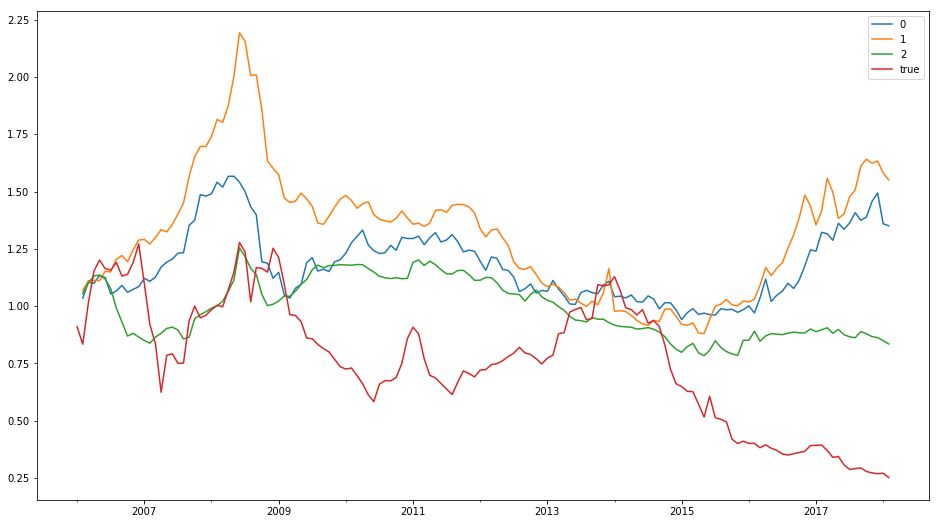

In [142]:
pd.DataFrame(pred).plot(figsize=(16, 9), label='predict')
nav.plot(figsize=(16, 9), label = 'true')
plt.legend()
print pd.DataFrame(pred).mean(axis=1).corr(nav)

In [57]:
scenario = fea[(fea.index >= '2009-01-01') & (fea.index <= '2010-01-01')]

In [58]:
sc_nav = nav[(nav.index >= scenario.index[0]) & (nav.index <= scenario.index[-1])]

In [59]:
scenario.shape, sc_nav.shape

((12, 114), (12L,))

In [60]:
lasso = linear_model.LassoCV(alphas=[0.01, 0.05, 0.1, 0.5, 1])

In [61]:
lasso.fit(scenario, sc_nav)

LassoCV(alphas=[0.01, 0.05, 0.1, 0.5, 1], copy_X=True, cv=None, eps=0.001,
    fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=1,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [77]:
ldf.loc[scenario.columns[lasso.coef_ != 0]].drop_duplicates()

,名称
代码,
M0009973,月度新增人民币贷款
S0035997,公路货运周转量
S0026990,原煤产量
S0027098,纯碱产量
M0000271,美元指数
M0055579,苏州商品房销售面积
S0049494,上交所铝库存


In [63]:
pred_nav = lasso.predict(fea)

In [64]:
pred_nav = pd.Series(pred_nav, index=nav.index)
pred_nav = (1 + pred_nav.pct_change()).cumprod()

0.281620707081
0.371345406757


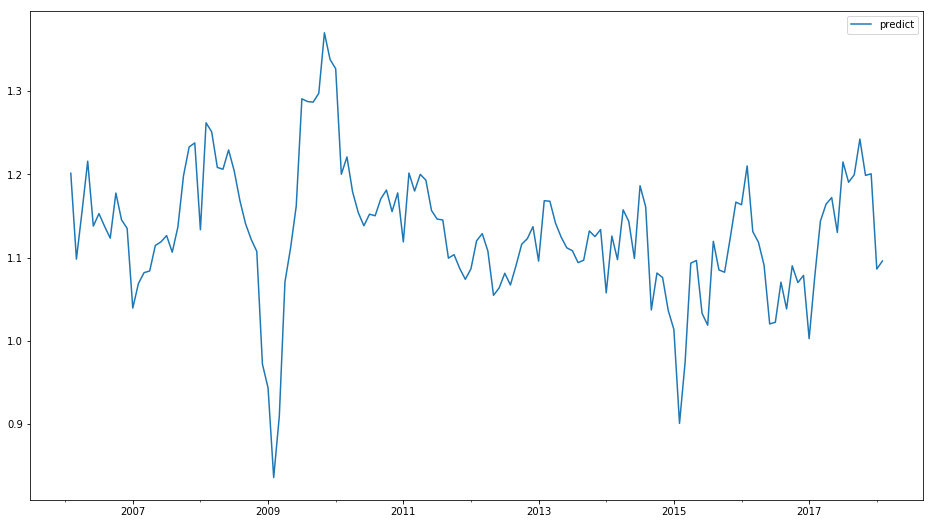

In [76]:
pred_nav.plot(figsize=(16, 9), label='predict')
# (1 + rdf[code]).cumprod().plot(figsize=(16, 9), label='true')
plt.legend()
print pred_nav.corr(nav)
print pred_nav.corr((1 + rdf[code]).cumprod())

In [75]:
pd.DataFrame({'true': (1 + rdf[code]).cumprod(), 'pred': pred_nav}).to_excel(u'D:/周期股牛市.xlsx')